In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm, trange
import pickle
np.random.seed(114)

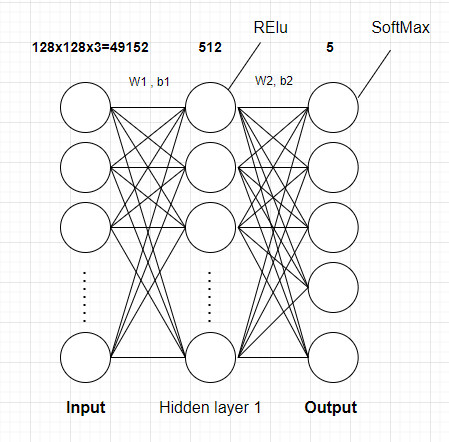

In [2]:
def split_flatten(x):
    b,g,r = cv2.split(x)
    return np.concatenate((b.flatten(),g.flatten(),r.flatten()))

In [3]:
def convertBGR2RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
def get_path(path_in):
    path = []
    label = ''
    for dirname, _, filenames in os.walk(path_in):
        for filename in filenames:
            label = dirname.split('/')[-1]
            path.append([os.path.join(dirname, filename),label])
    path = np.array(path)
    np.random.shuffle(path)
    return path

In [5]:
def load_data(path):
    X = []
    y = []
    for (filename,label) in path:
        img = cv2.imread(filename)
        if img.shape[0] ==128:
            X.append(img)
            y.append(label)
    return np.array(X),np.array(y)

### Train data

In [6]:
def handle_x(X):
    X_flatten = np.array([split_flatten(x) for x in X])
    X_train = np.array([X_flatten[0]])
    for x in X_flatten[1:]:
        X_train = np.vstack((((X_train,x.T))))
    X_train = X_train.astype(float) / 255.
    X_train = X_train.T
    return X_train

In [7]:
def one_hot(y,label):
    lb = LabelBinarizer()
    lb.fit(label)
    return lb.transform(y).T

In [8]:
path = get_path('/kaggle/input/fruidfullsize/data')
label = list(set([x[1] for x in path]))
label.sort()
X,y = load_data(path)
print('done!!!')

done!!!


In [9]:
XTrain, XTest, YTrain, YTest = train_test_split(X, y, test_size=0.1, random_state=114)
XTrain, XValid, YTrain, YValid = train_test_split(XTrain, YTrain, test_size=0.2, random_state=114)


X_train = handle_x(XTrain)
X_valid = handle_x(XValid)
X_test = handle_x(XTest)

print('done!!!')

done!!!


In [10]:
y_train = one_hot(YTrain,label)
y_valid = one_hot(YValid,label)
y_test = one_hot(YTest,label)

In [11]:
X_train.shape, y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape, label

((49152, 4076),
 (5, 4076),
 (49152, 1019),
 (5, 1019),
 (49152, 567),
 (5, 567),
 ['chuoi', 'oi', 'quyt', 'tao', 'xoai'])

### Xem qua về tập data

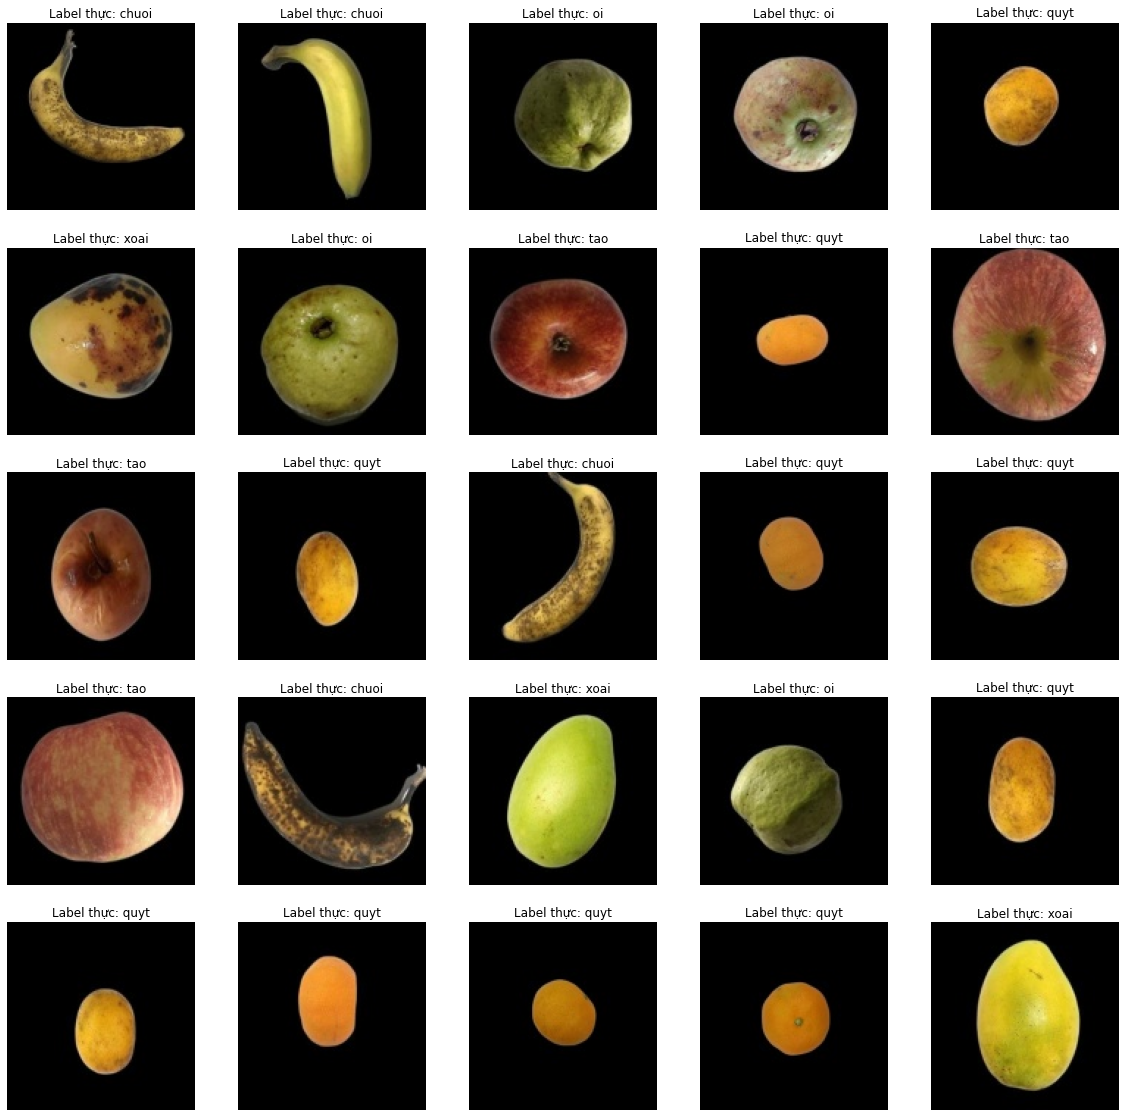

In [12]:
plt.figure(figsize=(20, 20))
# y_pred = model.predict(X_test)
# print(y_pred)
n = 1
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.title(f"Label thực: {label[np.argmax(y_train[:,n+i])]}")
    plt.imshow(convertBGR2RGB(XTrain[i+n]), cmap='gray')
    plt.axis('off')

## Model

In [13]:
class Layer:
    def __init__(self) -> None:
        pass

    def forward(self, input):
        pass

class Dense(Layer):
    def __init__(self, input_size, output_size) -> None:
        self.W = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros((output_size, 1))
        self.input = None
        self.output = None

    def forward(self, input):
        self.input = input
        self.output = np.dot(self.W.T, input) + self.b
        return self.output

    def backward(self, output_grad):
        input_grad = np.dot(self.W, output_grad)
        self.dW = np.dot(self.input, output_grad.T)
        self.db = np.sum(output_grad, axis=1, keepdims=True)
        return input_grad

    def update(self, learning_rate):
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db


class ReLU(Layer):
    def __init__(self) -> None:
        self.input = None
        self.output = None

    def forward(self, input):
        self.input = input
        self.output = np.maximum(input, 0)
        return self.output

    def backward(self, output_grad):
        input_grad = output_grad.copy()
        input_grad[self.input <= 0] = 0
        return input_grad


class Softmax(Layer):
    def __init__(self) -> None:
        self.input = None
        self.output = None

    def forward(self, input):
        self.input = input
        self.output = np.exp(input - np.max(input, axis=0, keepdims=True))
        self.output /= np.sum(self.output, axis=0, keepdims=True)
        return self.output

    def backward(self, output_grad):
#         input_grad = self.output * (output_grad - np.sum(output_grad * self.output, axis=0, keepdims=True))
#         return input_grad
        return output_grad


class Model:
    def __init__(self) -> None:
        self.layers = []
        self.losses_train=[] 
        self.accuracies_train = []
        self.losses_valid = []
        self.accuracies_valid = []
    
    def add(self, layer):
        self.layers.append(layer)
    
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, output_grad):
        for layer in reversed(self.layers):
            output_grad = layer.backward(output_grad)

    def update(self, learning_rate):
        for layer in self.layers:
            if isinstance(layer, Dense):
                layer.update(learning_rate)
# t = 
# for i in t:
    
#     sleep(0.01)
    
    
    
    def fit(self, X, y, X_valid, y_valid, epochs, batch_size, learning_rate, stop_early_steps=5):
        for epoch in range(epochs):
            print('Epoch: ', epoch + 1)
            t = trange(0, X.shape[1], batch_size)
            for i in t:
                X_batch = X[:, i:i + batch_size]
                y_batch = y[:, i:i + batch_size]
                y_pred = self.forward(X_batch)
                loss = self.loss(y_pred, y_batch)
                accuracy = self.accuracy(y_pred, y_batch)
                t.set_postfix_str('loss: {:.2f}  accuracy: {:.2f}'.format(loss,accuracy))
                output_grad = self.gradient(y_pred, y_batch)
                self.backward(output_grad)
                self.update(learning_rate)
            y_pred_test = self.forward(X)
            y_pred_valid = self.forward(X_valid)
            self.losses_train.append(self.loss(y_pred_test, y))
            self.accuracies_train.append(self.accuracy(y_pred_test, y))
            self.losses_valid.append(self.loss(y_pred_valid, y_valid))
            self.accuracies_valid.append(self.accuracy(y_pred_valid, y_valid))
            print('Train loss: ', self.losses_train[-1], 'Train accuracy: ', self.accuracies_train[-1])
            print('loss valid: ', self.losses_valid[-1], ' accuracy valid: ', self.accuracies_valid[-1])
            if self.accuracies_valid[-1] > 0.99:
                print('done!!! with accuracy valid: ', self.accuracies_valid[-1])
            if len(self.accuracies_valid) > stop_early_steps:
                if self.accuracies_valid[-1] < min(self.accuracies_valid[:-stop_early_steps]):
                    print('Early stopping!')
                    break
    def predict(self, X):
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=0)

    def loss(self, y_pred, y_true):
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / y_true.shape[1]

    def gradient(self, y_pred, y_true):
        return (y_pred - y_true)/y_true.shape[1]
    
    def accuracy(self, y_pred, y_true):
        return np.mean(np.argmax(y_pred, axis=0) == np.argmax(y_true, axis=0))
    
#     def save_model(self, path):
#         params = {}
#         params['Layers'] = self.layers
#         for i, layer in enumerate(self.layers):
#             if isinstance(layer, Dense):
#                 params['W' + str(i)] = layer.W
#                 params['b' + str(i)] = layer.b
#         np.savez(path, **params)
      
#     def load_model(self, path):
#         params = np.load(path)
#         for i, layer in enumerate(self.layers):
#             if isinstance(layer, Dense):
#                 layer.W = params['W' + str(i)]
#                 layer.b = params['b' + str(i)]  
    def save_model(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)

      
    def load_model(self, path):
        with open(path, 'rb') as f:
            model = pickle.load(f)
        return model
                
    def history(self):
        return self.losses_train,self.accuracies_train, self.losses_valid, self.accuracies_valid
    
    

In [14]:
model = Model()
model.add(Dense(X_train.shape[0], 512))
model.add(ReLU())
model.add(Dense(512, 5))
# model.add(ReLU())
# model.add(Dense(512, 5))
model.add(Softmax())
# model.fit(X_train, y_train,,32, 10, 0.005)
model.fit(X_train, y_train, X_valid, y_valid, epochs=30, batch_size=16, learning_rate=0.005)

Epoch:  1


100%|██████████| 255/255 [02:10<00:00,  1.95it/s, loss: 0.70  accuracy: 0.83]


Train loss:  0.6396936488559252 Train accuracy:  0.8569676153091266
loss valid:  0.6684651342300152  accuracy valid:  0.8645731108930323
Epoch:  2


100%|██████████| 255/255 [02:10<00:00,  1.95it/s, loss: 0.32  accuracy: 0.92]


Train loss:  0.334618656152184 Train accuracy:  0.9158488714425908
loss valid:  0.3547695320724347  accuracy valid:  0.914622178606477
Epoch:  3


100%|██████████| 255/255 [02:10<00:00,  1.96it/s, loss: 0.23  accuracy: 0.92]


Train loss:  0.23482073384433333 Train accuracy:  0.9403827281648676
loss valid:  0.25318561673893597  accuracy valid:  0.930323846908734
Epoch:  4


100%|██████████| 255/255 [02:11<00:00,  1.94it/s, loss: 0.18  accuracy: 0.92]


Train loss:  0.1822682015056678 Train accuracy:  0.9524043179587831
loss valid:  0.20092203680900378  accuracy valid:  0.9440628066732091
Epoch:  5


100%|██████████| 255/255 [02:10<00:00,  1.95it/s, loss: 0.14  accuracy: 0.92]


Train loss:  0.14815778596897883 Train accuracy:  0.9646712463199215
loss valid:  0.16812188809998208  accuracy valid:  0.9528949950932286
Epoch:  6


100%|██████████| 255/255 [02:12<00:00,  1.92it/s, loss: 0.11  accuracy: 0.92]


Train loss:  0.1244195708749021 Train accuracy:  0.9695780176643768
loss valid:  0.146273246518532  accuracy valid:  0.956820412168793
Epoch:  7


100%|██████████| 255/255 [02:11<00:00,  1.94it/s, loss: 0.09  accuracy: 0.92]


Train loss:  0.10731733603045071 Train accuracy:  0.9749754661432777
loss valid:  0.13087034619366303  accuracy valid:  0.9597644749754661
Epoch:  8


100%|██████████| 255/255 [02:12<00:00,  1.92it/s, loss: 0.07  accuracy: 1.00]


Train loss:  0.09389547140492525 Train accuracy:  0.9776741903827282
loss valid:  0.11932300507106332  accuracy valid:  0.9636898920510304
Epoch:  9


100%|██████████| 255/255 [02:15<00:00,  1.88it/s, loss: 0.06  accuracy: 1.00]


Train loss:  0.08292071513992723 Train accuracy:  0.982090284592738
loss valid:  0.11016844689781172  accuracy valid:  0.9656526005888125
Epoch:  10


100%|██████████| 255/255 [02:11<00:00,  1.94it/s, loss: 0.06  accuracy: 1.00]


Train loss:  0.07446459017267579 Train accuracy:  0.9830716388616291
loss valid:  0.10326457750380477  accuracy valid:  0.9666339548577036
Epoch:  11


100%|██████████| 255/255 [02:15<00:00,  1.89it/s, loss: 0.05  accuracy: 1.00]


Train loss:  0.06700886146197298 Train accuracy:  0.9835623159960746
loss valid:  0.09695934877695288  accuracy valid:  0.9666339548577036
Epoch:  12


100%|██████████| 255/255 [02:13<00:00,  1.91it/s, loss: 0.05  accuracy: 1.00]


Train loss:  0.06059693667769131 Train accuracy:  0.9855250245338567
loss valid:  0.09207755137212077  accuracy valid:  0.9676153091265947
Epoch:  13


100%|██████████| 255/255 [02:12<00:00,  1.92it/s, loss: 0.05  accuracy: 1.00]


Train loss:  0.05502569092448769 Train accuracy:  0.9882237487733072
loss valid:  0.08764294788826713  accuracy valid:  0.9685966633954858
Epoch:  14


100%|██████████| 255/255 [02:12<00:00,  1.92it/s, loss: 0.04  accuracy: 1.00]


Train loss:  0.050349836117192466 Train accuracy:  0.9892051030421982
loss valid:  0.08379258432268097  accuracy valid:  0.9705593719332679
Epoch:  15


100%|██████████| 255/255 [02:12<00:00,  1.93it/s, loss: 0.04  accuracy: 1.00]


Train loss:  0.046172567864046846 Train accuracy:  0.9896957801766437
loss valid:  0.08059362807048102  accuracy valid:  0.971540726202159
Epoch:  16


100%|██████████| 255/255 [02:11<00:00,  1.94it/s, loss: 0.04  accuracy: 1.00]


Train loss:  0.04232335558448831 Train accuracy:  0.9904317958783121
loss valid:  0.07749593116273905  accuracy valid:  0.97252208047105
Epoch:  17


100%|██████████| 255/255 [02:13<00:00,  1.92it/s, loss: 0.04  accuracy: 1.00]


Train loss:  0.03921629703077168 Train accuracy:  0.9909224730127576
loss valid:  0.07519661998409491  accuracy valid:  0.971540726202159
Epoch:  18


100%|██████████| 255/255 [02:14<00:00,  1.89it/s, loss: 0.03  accuracy: 1.00]


Train loss:  0.03605905782811581 Train accuracy:  0.9919038272816487
loss valid:  0.07246168669102125  accuracy valid:  0.971540726202159
Epoch:  19


100%|██████████| 255/255 [02:15<00:00,  1.88it/s, loss: 0.03  accuracy: 1.00]


Train loss:  0.03349504940884405 Train accuracy:  0.9938665358194309
loss valid:  0.0705979939414658  accuracy valid:  0.9754661432777233
Epoch:  20


100%|██████████| 255/255 [02:27<00:00,  1.72it/s, loss: 0.03  accuracy: 1.00]


Train loss:  0.031020517807300682 Train accuracy:  0.9948478900883219
loss valid:  0.06840564665685582  accuracy valid:  0.9774288518155054
Epoch:  21


100%|██████████| 255/255 [02:13<00:00,  1.91it/s, loss: 0.03  accuracy: 1.00]


Train loss:  0.028873389863398925 Train accuracy:  0.9960745829244357
loss valid:  0.06693176340317072  accuracy valid:  0.9784102060843964
Epoch:  22


100%|██████████| 255/255 [02:16<00:00,  1.87it/s, loss: 0.03  accuracy: 1.00]


Train loss:  0.026998014468343903 Train accuracy:  0.9963199214916585
loss valid:  0.06547707090024227  accuracy valid:  0.9784102060843964
Epoch:  23


100%|██████████| 255/255 [02:11<00:00,  1.94it/s, loss: 0.02  accuracy: 1.00]


Train loss:  0.025177879225429668 Train accuracy:  0.996810598626104
loss valid:  0.06390879537934818  accuracy valid:  0.9793915603532876
Epoch:  24


100%|██████████| 255/255 [02:15<00:00,  1.88it/s, loss: 0.02  accuracy: 1.00]


Train loss:  0.023620571867361148 Train accuracy:  0.9973012757605496
loss valid:  0.06270575249020571  accuracy valid:  0.9793915603532876
Epoch:  25


100%|██████████| 255/255 [02:13<00:00,  1.91it/s, loss: 0.02  accuracy: 1.00]


Train loss:  0.022229890061170647 Train accuracy:  0.9975466143277724
loss valid:  0.0615763883160277  accuracy valid:  0.9793915603532876
Epoch:  26


100%|██████████| 255/255 [02:15<00:00,  1.88it/s, loss: 0.02  accuracy: 1.00]


Train loss:  0.020963130426937676 Train accuracy:  0.9980372914622179
loss valid:  0.06041359858395813  accuracy valid:  0.9784102060843964
Epoch:  27


100%|██████████| 255/255 [02:12<00:00,  1.93it/s, loss: 0.02  accuracy: 1.00]


Train loss:  0.019720500485272994 Train accuracy:  0.9980372914622179
loss valid:  0.05946395397500136  accuracy valid:  0.9793915603532876
Epoch:  28


100%|██████████| 255/255 [02:14<00:00,  1.90it/s, loss: 0.02  accuracy: 1.00]


Train loss:  0.01867390081796271 Train accuracy:  0.9982826300294406
loss valid:  0.058238736955602124  accuracy valid:  0.9803729146221786
Epoch:  29


100%|██████████| 255/255 [02:13<00:00,  1.91it/s, loss: 0.02  accuracy: 1.00]


Train loss:  0.017617920630648955 Train accuracy:  0.9985279685966634
loss valid:  0.057603800948766735  accuracy valid:  0.9803729146221786
Epoch:  30


100%|██████████| 255/255 [02:13<00:00,  1.91it/s, loss: 0.02  accuracy: 1.00]


Train loss:  0.016737188912822432 Train accuracy:  0.9987733071638861
loss valid:  0.057133198755534485  accuracy valid:  0.9813542688910697


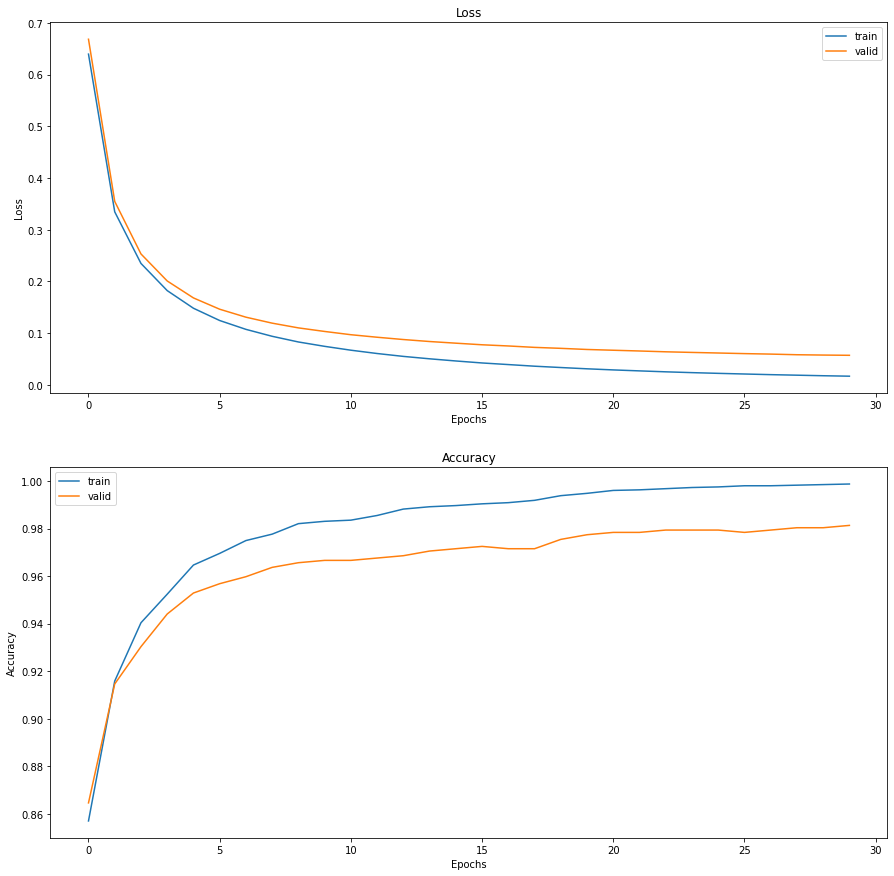

In [15]:
(loss_train,acc_train,loss_valid,acc_valid) = model.history()
plt.figure(figsize=(15, 15))
plt.subplot(2,1,1)
plt.plot(loss_train, label='train') 
plt.plot(loss_valid, label='valid')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(acc_train, label='train')
plt.plot(acc_valid, label='valid')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
y_pred = model.predict(X_test[:,1].reshape(-1,1))
y_pred

array([1])

Accuracy tập test: 0.9858906525573192


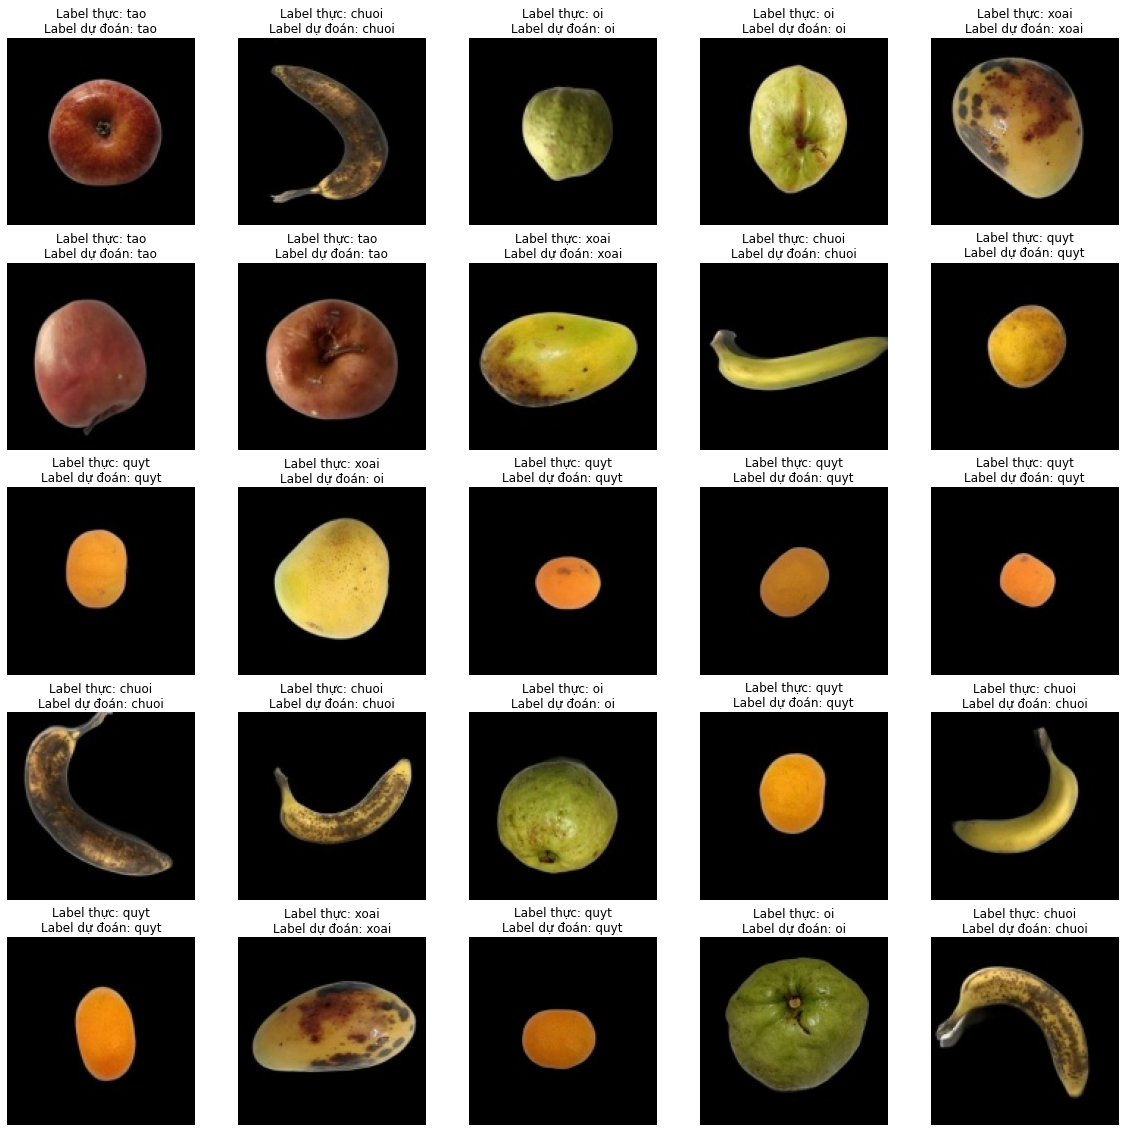

In [17]:
print(f'Accuracy tập test: {model.accuracy(model.forward(X_test), y_test)}')
plt.figure(figsize=(20, 20))
y_pred = model.predict(X_test)
# print(y_pred)
n = 10
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.title(f"Label thực: {label[np.argmax(y_test[:,n+i])]}\nLabel dự đoán: {label[y_pred[i+n]]}")
    plt.imshow(convertBGR2RGB(XTest[i+n]), cmap='gray')
    plt.axis('off')
    


In [18]:
# save model
model.save_model('model.pkl')

In [19]:
# load model
np.random.seed(114)
new_model  = Model()
new_model = new_model.load_model('/kaggle/input/testaa/model.pkl')
# predict
y_pred = new_model.predict(X_test[:,1].reshape(-1,1))
y_pred
# new_model.history()

array([1])

In [20]:
X_train.shape[0]

49152

Accuracy tập test: 0.9717813051146384


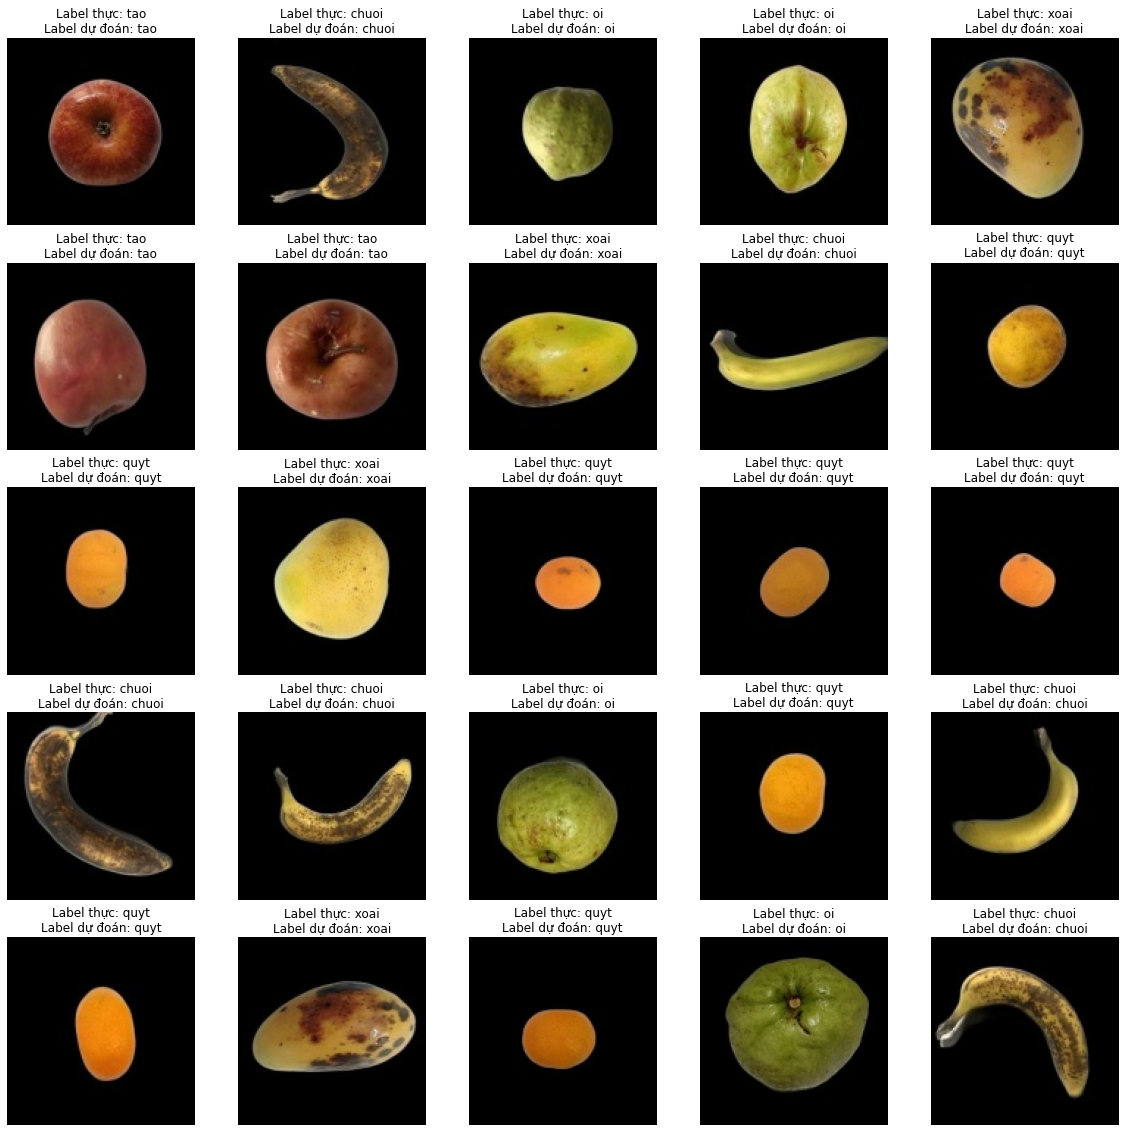

In [21]:
print(f'Accuracy tập test: {new_model.accuracy(new_model.forward(X_test), y_test)}')
plt.figure(figsize=(20, 20))
y_pred = new_model.predict(X_test)
# print(y_pred)
n = 10
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.title(f"Label thực: {label[np.argmax(y_test[:,n+i])]}\nLabel dự đoán: {label[y_pred[i+n]]}")
    plt.imshow(convertBGR2RGB(XTest[i+n]), cmap='gray')
    plt.axis('off')
    


In [22]:
#  save X_test
np.save('X_test.npy', X_test)
#  save y_test
np.save('y_test.npy', y_test)
# save XTest
np.save('XTest.npy', XTest)

In [23]:
np.save('labels.npy', label)

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Flatten,Conv2D,MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
batch_size = 16
num_classes = 5

In [25]:
# Build Network
model = Sequential()
model.add(Dense(512, activation='ReLU'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss = "categorical_crossentropy", 
             optimizer="sgd",
             metrics=['accuracy'])

2022-12-07 23:20:27.394311: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [26]:
epochs = 25
history = model.fit(X_train.T, y_train.T,
          batch_size=batch_size,
          epochs=epochs,
        verbose=1,
          validation_data=(X_valid.T, y_valid.T))

2022-12-07 23:20:31.666663: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
255/255 [==============================] - 15s 54ms/step - loss: 0.5374 - accuracy: 0.8101 - val_loss: 0.2332 - val_accuracy: 0.9401
Epoch 2/25
255/255 [==============================] - 13s 50ms/step - loss: 0.1888 - accuracy: 0.9426 - val_loss: 0.1423 - val_accuracy: 0.9598
Epoch 3/25
255/255 [==============================] - 13s 52ms/step - loss: 0.1258 - accuracy: 0.9620 - val_loss: 0.1329 - val_accuracy: 0.9519
Epoch 4/25
255/255 [==============================] - 13s 52ms/step - loss: 0.0959 - accuracy: 0.9703 - val_loss: 0.0956 - val_accuracy: 0.9784
Epoch 5/25
255/255 [==============================] - 13s 51ms/step - loss: 0.0774 - accuracy: 0.9794 - val_loss: 0.1893 - val_accuracy: 0.9333
Epoch 6/25
255/255 [==============================] - 13s 51ms/step - loss: 0.0673 - accuracy: 0.9796 - val_loss: 0.0814 - val_accuracy: 0.9784
Epoch 7/25
255/255 [==============================] - 12s 49ms/step - loss: 0.0571 - accuracy: 0.9833 - val_loss: 0.0781 - val_accuracy: